# SVD with TensorFlow

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import numpy as np
import scipy.spatial as sp
import tensorflow as tf

import matrices.loading as matload
import resources.dataset as rsdata

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
plt.rcParams["figure.figsize"] = (4,4)
mpl.rcParams['figure.dpi']= 200
mpl.rcParams['figure.titlesize']= 'small'
mpl.rcParams['font.size']= 6
mpl.rcParams['image.cmap'] = 'jet'
cmap = cm.get_cmap('jet')
cmap.set_bad('w') # Print bads as white

sess = tf.Session() # tensorflow

In [4]:
data_path = "resources/aminer/v1" # 629814 documents

In [5]:
# Load sparse matrix with jaccard similarities.
matrix_tmp = matload.load_matrix_jaccard_sim(data_path)

n = matrix_tmp.shape[0]

matrix_jaccard = tf.constant(matrix_tmp, name='matrix_jaccard')

# dice
matrix_dice = tf.constant(np.divide(np.multiply(2,matrix_tmp), np.add(matrix_tmp, 1)), name='matrix_dice')

# Jaccard disimilarity
matrix_jaccard_dis =  tf.constant(np.subtract(1, matrix_tmp), name='matrix_jaccard_dis')

del matrix_tmp

# Load sparse matrix with word2vec similarities.
matrix_tmp = matload.load_matrix_word2vec_sim(data_path)

matrix_word2vec = tf.constant(matrix_tmp, name='matrix_word2vec')

del matrix_tmp

pltmask =  np.tri(n, k=-1) # Mask to plot upper triangular matrix.   

# Load document ids in the Same order than the matrices
indexdocs = matload.get_document_ids(data_path)

print("\nMatrices.")
print(matrix_jaccard)
print(matrix_jaccard_dis)
print(matrix_dice)
print(matrix_word2vec)

Loading saved matrix ...
Loading saved matrix ...

Matrices.
Tensor("matrix_jaccard:0", shape=(998, 998), dtype=float32)
Tensor("matrix_jaccard_dis:0", shape=(998, 998), dtype=float32)
Tensor("matrix_dice:0", shape=(998, 998), dtype=float32)
Tensor("matrix_word2vec:0", shape=(998, 998), dtype=float32)


In [6]:
# Tensors 
M = tf.Variable(tf.zeros((n,n),  dtype=tf.float32), dtype=tf.float32, name='M') 
s, u, v = tf.svd(M) #SVD

# ns = n
ns = 1 # one singular value

# UDV' matrix reconstruction with ns singular values
M_ = tf.matmul(u[:,:ns], tf.matmul(tf.diag(s[:ns]), v[:,:ns], adjoint_b=True)) 
# M_ = tf.matmul(u[:,:ns], v[:,:ns], adjoint_b=True) # UV'

sess.run(tf.global_variables_initializer())  

print("Tensors for SVD. \nM_ is the reconstruction of the matrix M with %d singular value(s)." % (ns))

Tensors for SVD. 
M_ is the reconstruction of the matrix M with 1 singular value(s).


In [7]:
op = M.assign(matrix_jaccard)
sess.run(op)
jaccard_approximation = sess.run(M_) # Reconstruction of the matrix M
jaccard_singular_values = sess.run(s) # Singular values  

op = M.assign(matrix_jaccard_dis)
sess.run(op)
jaccarddis_approximation = sess.run(M_)
jaccarddis_singular_values = sess.run(s)

op = M.assign(matrix_dice)
sess.run(op)
dice_approximation = sess.run(M_)
dice_singular_values = sess.run(s)

op = M.assign(matrix_word2vec)
sess.run(op)
word2vec_approximation = sess.run(M_)
word2vec_singular_values = sess.run(s)

print("Matrix reconstructions using %d singular value(s)" % (ns))

Matrix reconstructions using 1 singular value(s)


In [8]:
print("SVD: Largest singular values:\n \
        \nJaccard sim. s0 = %f \nJaccard dis. s0 = %f \nDice sim. s0 = %f \
        \nwod2vec sim. s0 = %f" % (jaccard_singular_values[0], jaccarddis_singular_values[0], 
      dice_singular_values[0], word2vec_singular_values[0]))

SVD: Largest singular values:
         
Jaccard sim. s0 = 9.587548 
Jaccard dis. s0 = 990.752136 
Dice sim. s0 = 16.390749         
wod2vec sim. s0 = 101.521500


### Plotting the matrix approximations

In the following graphs $s_0$ is not plotted because it is too large in the cases of wod2vec and jaccard disimilarities. 

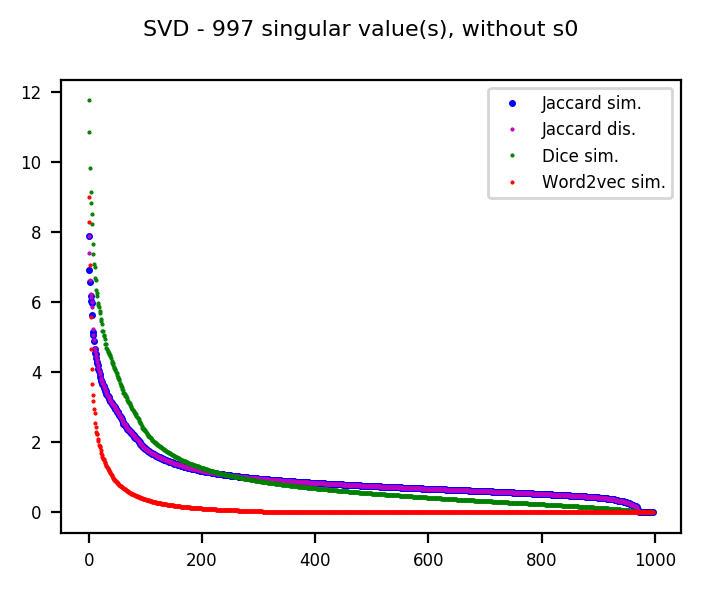

In [9]:
fig = plt.figure(figsize=(4, 3))
fig.suptitle("SVD - %d singular value(s), without s0" % (n - 1), fontsize=8)

# Plotting singular values. s0 is too large for word2vec
ax1 = plt.subplot(1, 1, 1)
ax1.plot(jaccard_singular_values[1:], 'b.', mew=1.0, ms=3.0, label="Jaccard sim.")
ax1.plot(jaccarddis_singular_values[1:], 'm.', mew=1.0, ms=1.0, label="Jaccard dis.")
ax1.plot(dice_singular_values[1:], 'g.', mew=1.0, ms=1.0, label="Dice sim.")
ax1.plot(word2vec_singular_values[1:], 'r.', mew=1.0, ms=1.0, label="Word2vec sim.")

plt.legend()
plt.show()

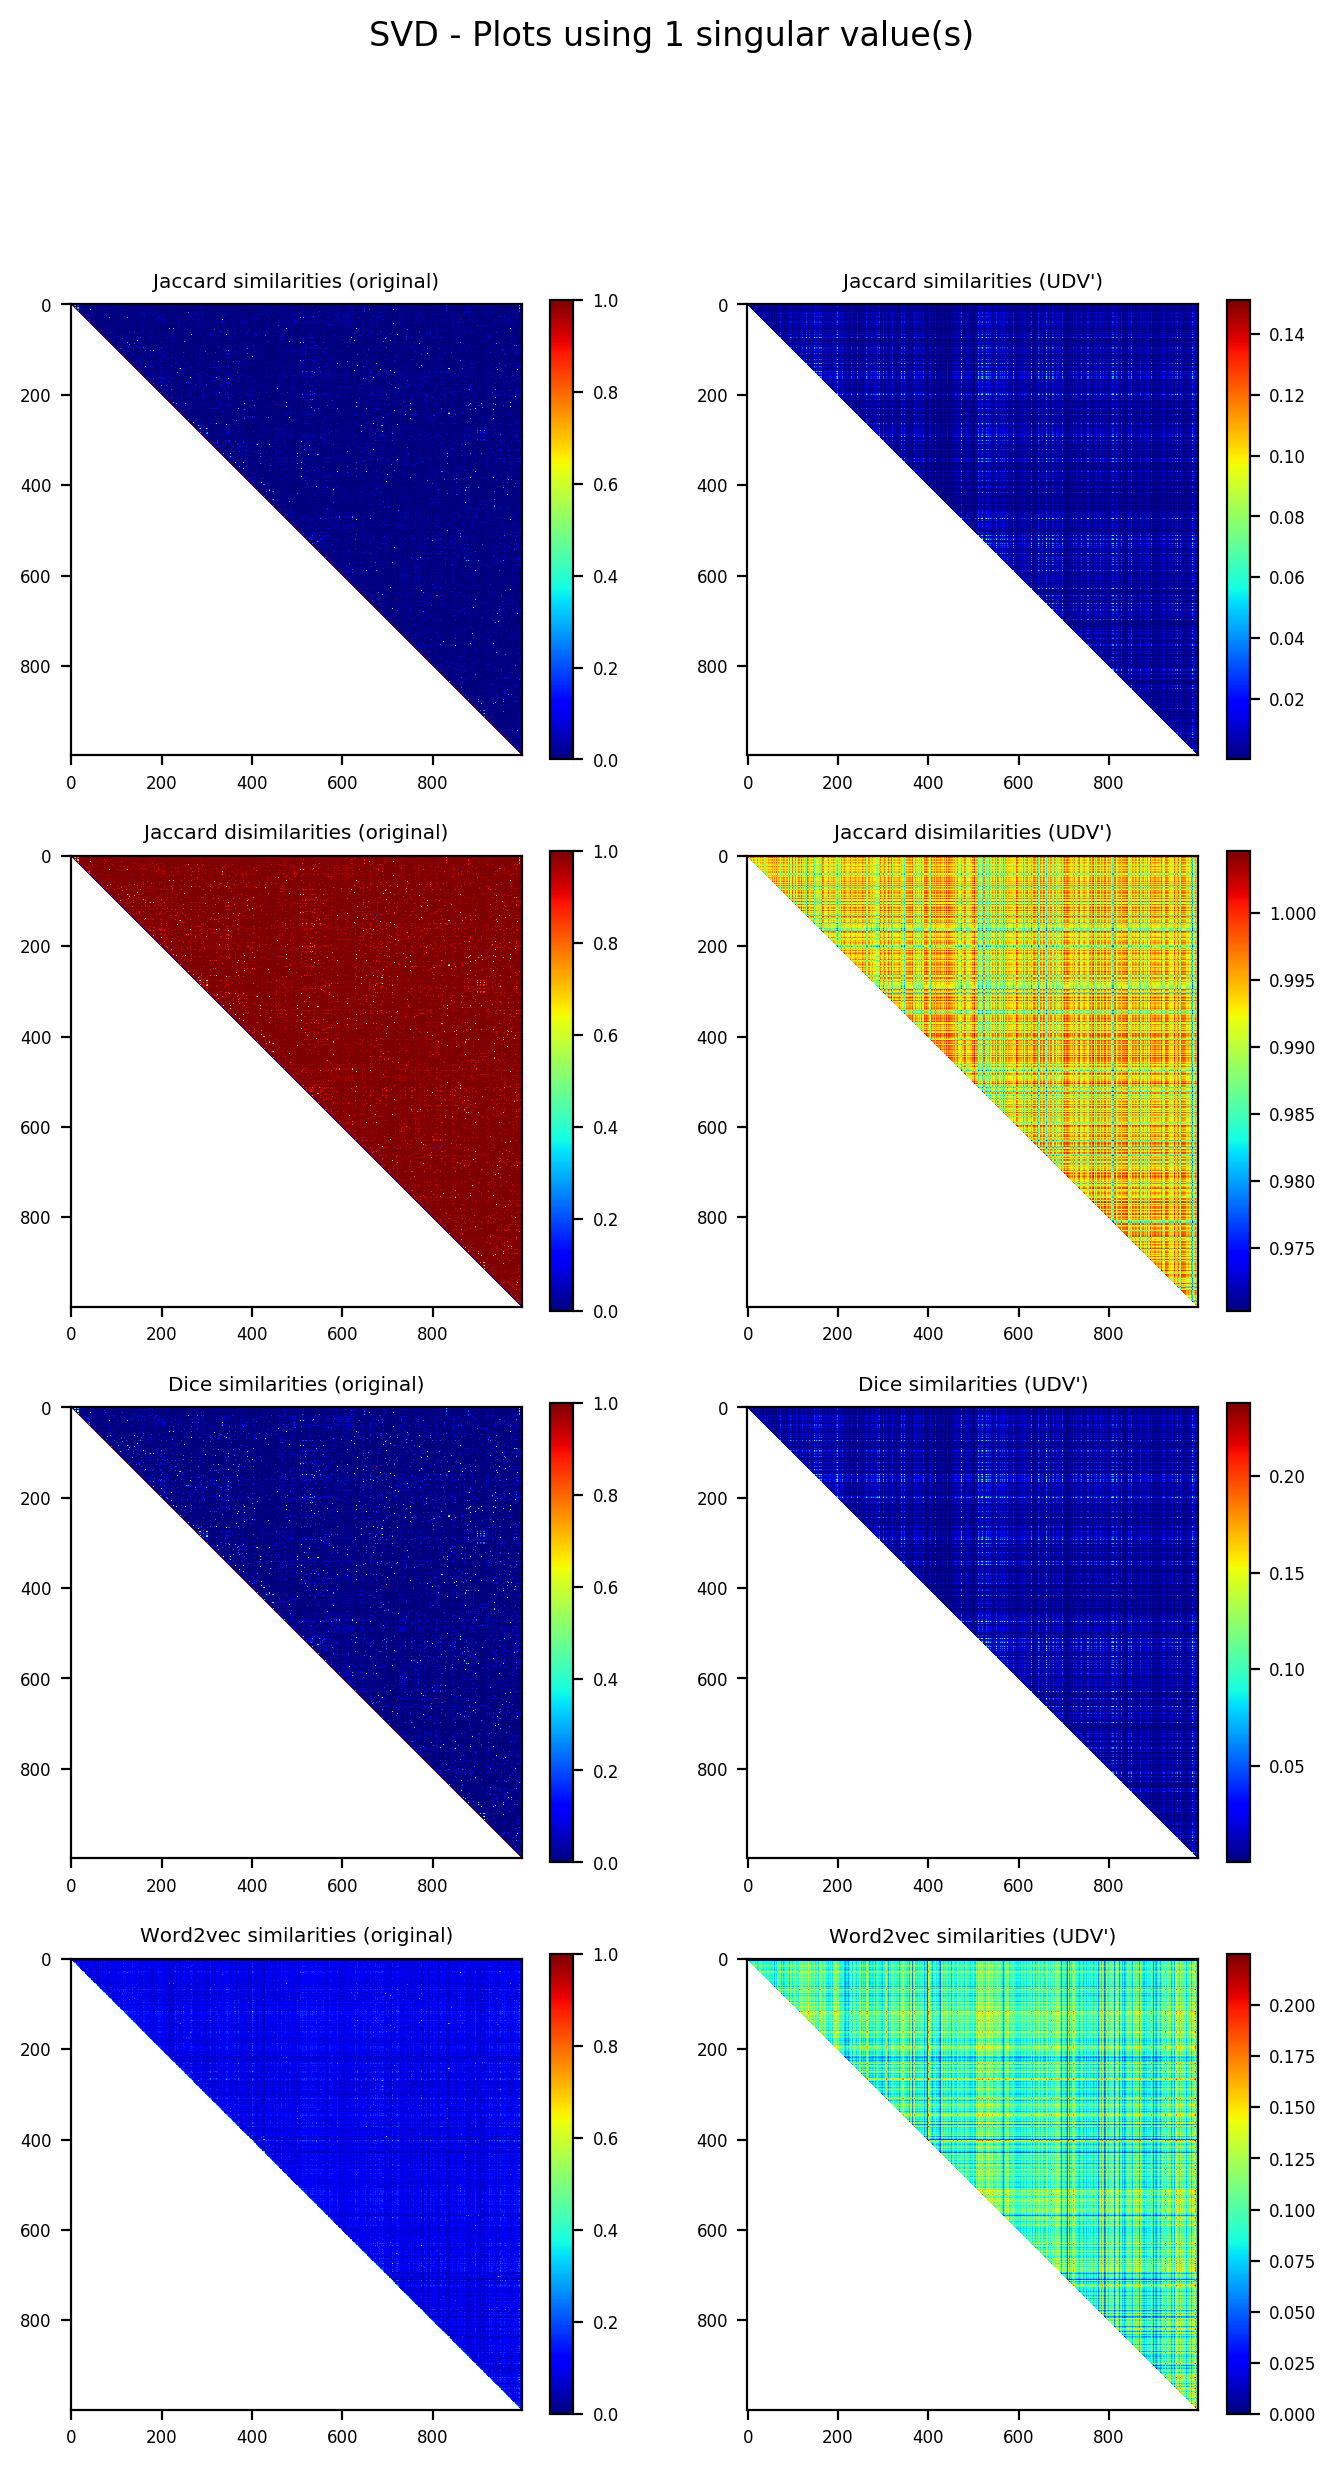

In [32]:
fig = plt.figure(figsize=(8,14))
fig.suptitle("SVD - Plots using %d singular value(s)" % (ns), fontsize=12)

ax_jaccard = plt.subplot(4, 2, 1)
ax_jaccard.set_title("Jaccard similarities (original)")
im_jaccard = ax_jaccard.imshow(np.ma.array(sess.run(matrix_jaccard), mask=pltmask))
plt.colorbar(im_jaccard)
# Reconstructed matrix using the largest singular value.
ax_jaccard_ = plt.subplot(4, 2, 2)
ax_jaccard_.set_title("Jaccard similarities (UDV')")
im_jaccard_ = ax_jaccard_.imshow(np.ma.array(jaccard_approximation, mask=pltmask))

plt.colorbar(im_jaccard_)

ax_jaccard_dis = plt.subplot(4, 2, 3)
ax_jaccard_dis.set_title("Jaccard disimilarities (original)")
im_jaccarddis = ax_jaccard_dis.imshow(np.ma.array(sess.run(matrix_jaccard_dis), mask=pltmask))
plt.colorbar(im_jaccarddis)
# Reconstructed matrix using the largest singular value.
ax_jaccard_dis_ = plt.subplot(4, 2, 4)
ax_jaccard_dis_.set_title("Jaccard disimilarities (UDV')")
im_jaccarddis_ = ax_jaccard_dis_.imshow(np.ma.array(jaccarddis_approximation, mask=pltmask))
plt.colorbar(im_jaccarddis_)

ax_dice = plt.subplot(4, 2, 5)
ax_dice.set_title("Dice similarities (original)")
im_dice = ax_dice.imshow(np.ma.array(sess.run(matrix_dice), mask=pltmask))
plt.colorbar(im_dice)
# Reconstructed matrix using the largest singular value.
ax_dice_ = plt.subplot(4, 2, 6)
ax_dice_.set_title("Dice similarities (UDV')")
im_dice_ = ax_dice_.imshow(np.ma.array(dice_approximation, mask=pltmask))
plt.colorbar(im_dice_)

ax_word2vec = plt.subplot(4, 2, 7)
ax_word2vec.set_title("Word2vec similarities (original)")
im_word2vec = ax_word2vec.imshow(np.ma.array(sess.run(matrix_word2vec), mask=pltmask))
plt.colorbar(im_word2vec)
# Reconstructed matrix using the largest singular value.
ax_word2vec_ = plt.subplot(4, 2, 8)
ax_word2vec_.set_title("Word2vec similarities (UDV')")
im_word2vec_ = ax_word2vec_.imshow(np.ma.array(word2vec_approximation, mask=pltmask))
plt.colorbar(im_word2vec_)

plt.show()

### Ordering matrices for better visualization 

From the matrix approximations with SVD is calculated the mean for each column. Later, the means are used to order the matrices. 

In [11]:
# Means of jaccard similarities using the reconstructed matrix 
jaccard_similarity_mean = tf.reduce_mean(jaccard_approximation, 1)
# Ordered indices by mean of similarities in the approximation
jaccard_indices = sess.run(jaccard_similarity_mean).argsort()[::-1]

# Means of word2vec similarities using the reconstructed matrix 
word2vec_similarity_mean = tf.reduce_mean(word2vec_approximation, 1)
# Ordered indices by mean of similarities in the approximation
word2vec_indices = sess.run(word2vec_similarity_mean).argsort()[::-1]

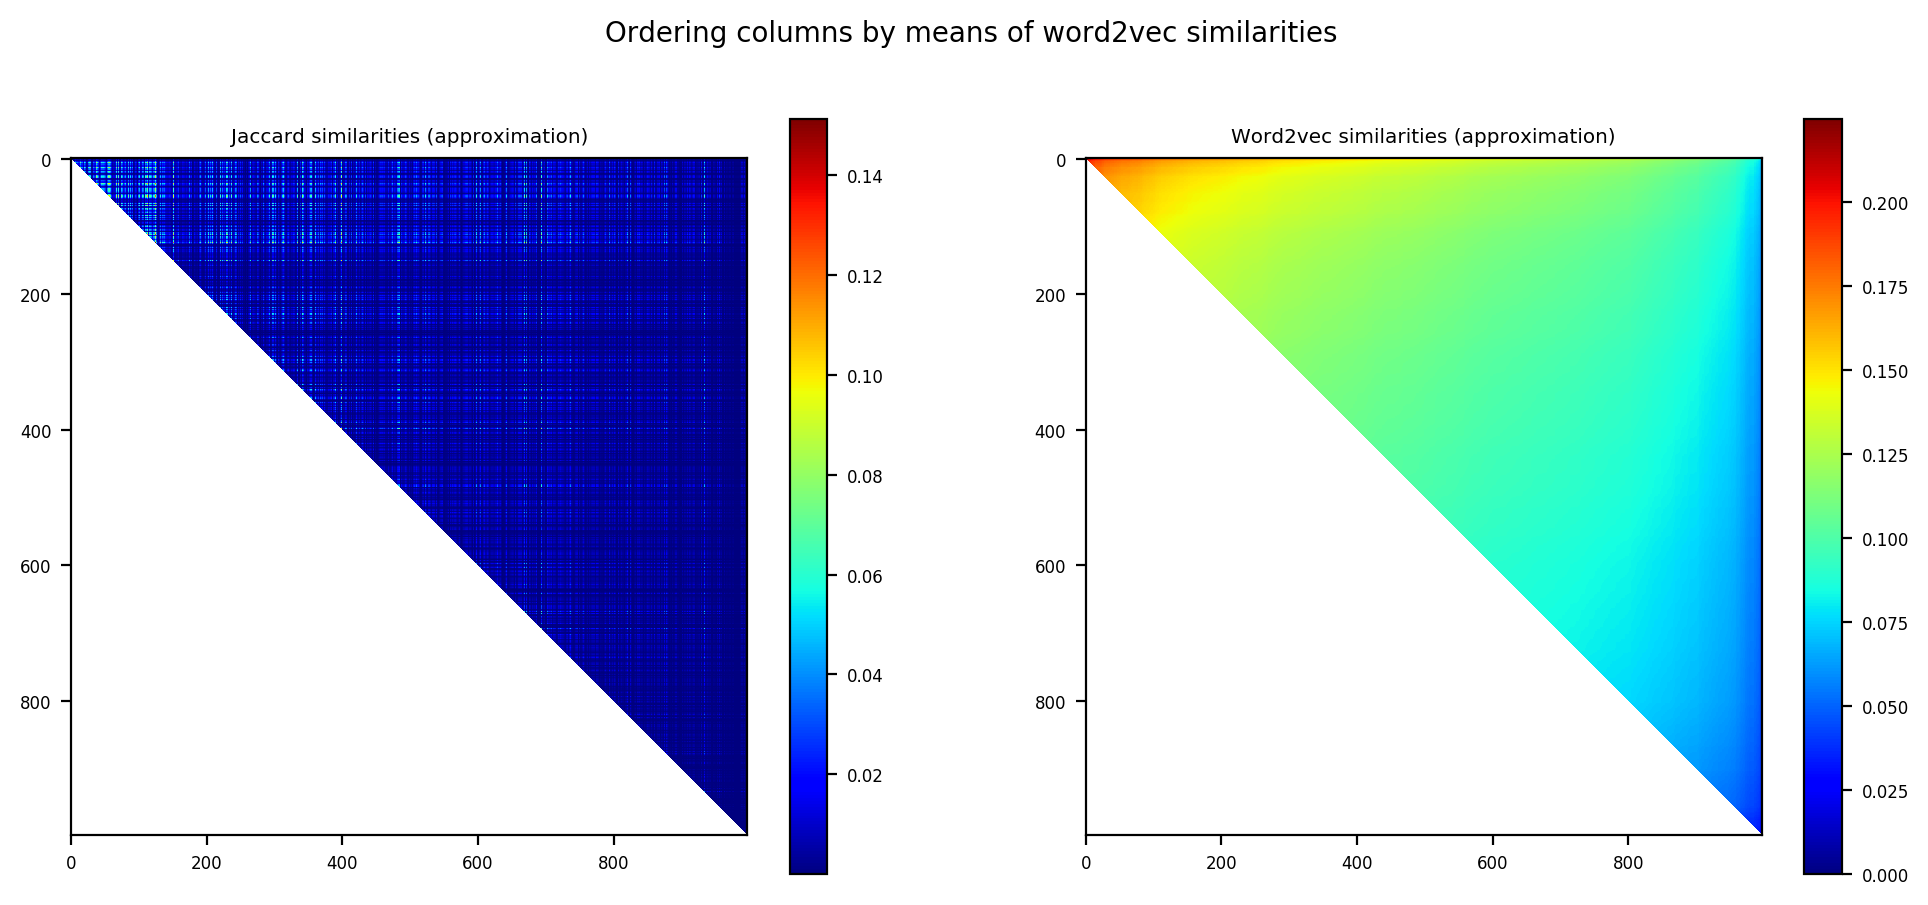

In [36]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Ordering columns by means of word2vec similarities", fontsize=10)

ax_jaccard = plt.subplot(1, 2, 1)
ax_jaccard.set_title("Jaccard similarities (approximation)")
im_jaccard_arranged = ax_jaccard.imshow(np.ma.array(
    jaccard_approximation[:,word2vec_indices][word2vec_indices,:], mask=pltmask))
plt.colorbar(im_jaccard_arranged)

ax_word2vec = plt.subplot(1, 2, 2)
ax_word2vec.set_title("Word2vec similarities (approximation)")
im_word2vec_arranged = ax_word2vec.imshow(np.ma.array(
    word2vec_approximation[:,word2vec_indices][word2vec_indices,:], mask=pltmask))
plt.colorbar(im_word2vec_arranged)

plt.show()

A mask is generated from jaccard similarities, given $s_{ij} \in S$ with S being the matrix, the mask is the matrix K.

\begin{equation}
  k_{ij}=\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ s_{ij}=0 \\
    0, & \text{otherwise}
  \end{array}\right.
\end{equation} 

Each similarity equal to zero with jaccard means that between two documents there is not a correspondence in words.

In [13]:
# Mask
jaccard_mask = sess.run(tf.where( tf.equal(matrix_jaccard, 0.0), 
                                 tf.ones(matrix_jaccard.get_shape()), tf.zeros(matrix_jaccard.get_shape())))

jaccard_mask_ordered = jaccard_mask[:,word2vec_indices][word2vec_indices,:]

with sess.as_default():
    print("Jaccard matrix\n", matrix_jaccard[:3,:3].eval())
    print("\nJaccard mask\n", jaccard_mask[:3,:3])

Jaccard matrix
 [[1.         0.14285715 0.        ]
 [0.14285715 1.         0.        ]
 [0.         0.         1.        ]]

Jaccard mask
 [[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 0.]]


The mask is aplyed over word2vec by multiplying each element in the matrix $s_{ij}k_{ij}$ (not matrix multiplication).

In [14]:
# Mask over word2vec
jaccardmask_word2vecapprox = sess.run(tf.convert_to_tensor(jaccard_mask)*word2vec_approximation)
jaccardmask_word2vecapprox_ordered = jaccardmask_word2vecapprox[:,word2vec_indices][word2vec_indices,:]

with sess.as_default():
    # The resulting word2vec matrix keeps only values of similitaties 
    # where jaccard has a similarity of zero
    print("Small example with the mask.")
    print("\nword2vec (approx.)\n", word2vec_approximation[:3,:3])
    print("\nMaskered word2vec\n", jaccardmask_word2vecapprox[:3,:3])

Small example with the mask.

word2vec (approx.)
 [[0.07846789 0.06433386 0.10137664]
 [0.06433419 0.05274599 0.0831166 ]
 [0.10137682 0.08311632 0.13097385]]

Maskered word2vec
 [[0.         0.         0.10137664]
 [0.         0.         0.0831166 ]
 [0.10137682 0.08311632 0.        ]]


This mask is only used to illustrate that similar documents don't necessarily have co-occurrence of words. 

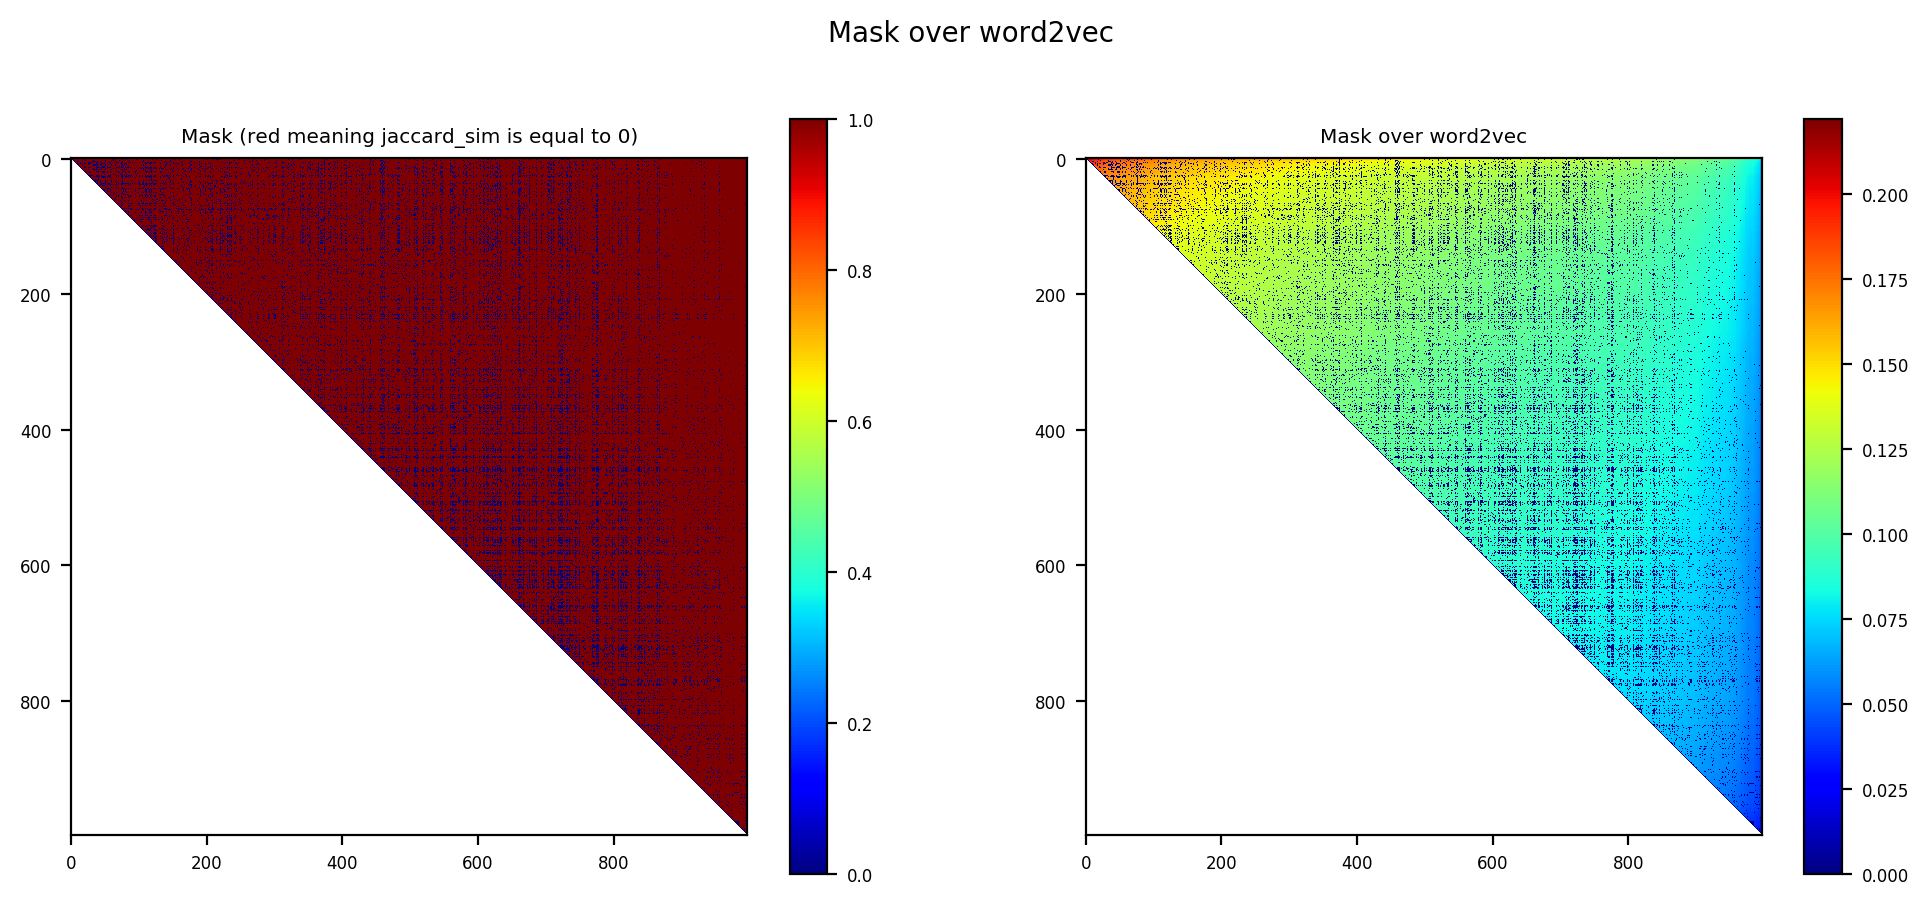

In [38]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Mask over word2vec", fontsize=10)

ax_mask = plt.subplot(1, 2, 1)
ax_mask.set_title("Mask (red meaning jaccard_sim is equal to 0)")
im_mask = ax_mask.imshow(
                np.ma.array(
                    jaccard_mask_ordered, 
                    mask=pltmask
                )
            )
plt.colorbar(im_mask)

ax_jm_wa = plt.subplot(1, 2, 2)
ax_jm_wa.set_title("Mask over word2vec")
im_jm_wa = ax_jm_wa.imshow(
                np.ma.array(
                    jaccardmask_word2vecapprox_ordered, 
                    mask=pltmask
                )
            )
plt.colorbar(im_jm_wa)
plt.show()

In [16]:
size_submatrix = 200
subpltmask = pltmask[:size_submatrix,:size_submatrix]

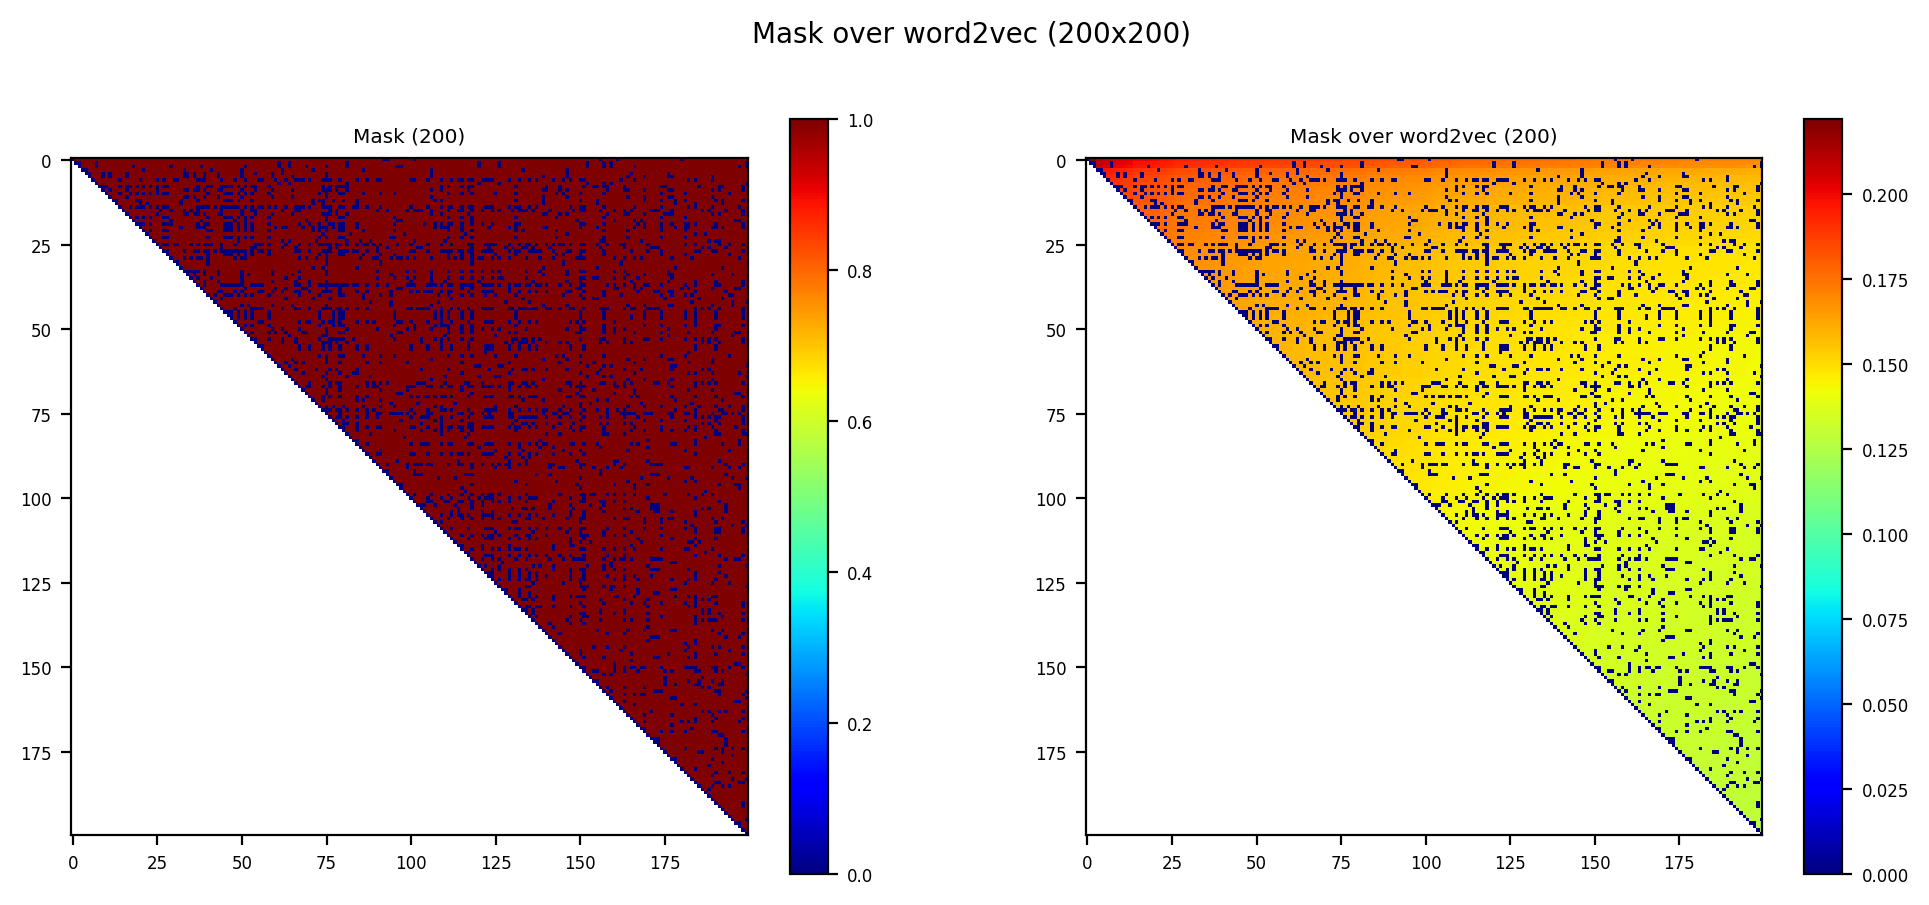

In [39]:
fig = plt.figure(figsize=(12,5))
fig.suptitle("Mask over word2vec (%dx%d)" % (size_submatrix, size_submatrix) , fontsize=10)

ax_mask_seg = plt.subplot(1, 2, 1)
ax_mask_seg.set_title("Mask (%d)" % size_submatrix )
im_mask_seg = ax_mask_seg.imshow(
                np.ma.array(
                    jaccard_mask_ordered[:size_submatrix,:size_submatrix], 
                    mask=subpltmask
                )
            )
plt.colorbar(im_mask_seg)

ax_jm_wa_seg = plt.subplot(1, 2, 2)
ax_jm_wa_seg.set_title("Mask over word2vec (%d)" % size_submatrix )
im_jm_wa_seg = ax_jm_wa_seg.imshow(
                np.ma.array(
                    jaccardmask_word2vecapprox_ordered[:size_submatrix,:size_submatrix], 
                    mask=subpltmask
                )
            )
plt.colorbar(im_jm_wa_seg)

plt.show()

In [18]:

def freq_zero_jaccard_sim_triu(JM):
    N_JM_i, N_JM_j = JM.shape
    zero_sim = 0
    gt_zero = 0
    total_values = 0
    for i in range(0, N_JM_i):
        j = i+1
        while j < N_JM_j:
            total_values += 1
            if JM[i,j] == 1:
                zero_sim += 1
            else:
                gt_zero += 1
            j += 1
    return zero_sim/total_values, gt_zero/total_values

def freq_zero_jaccard_sim_full(JM):
    N_JM_i, N_JM_j = JM.shape
    zero_sim = 0
    gt_zero = 0
    total_values = 0
    for i in range(0, N_JM_i):
        j = 0
        while j < N_JM_j:
            total_values += 1
            if JM[i,j] == 1:
                zero_sim += 1
            else:
                gt_zero += 1
            j += 1
    return zero_sim/total_values, gt_zero/total_values

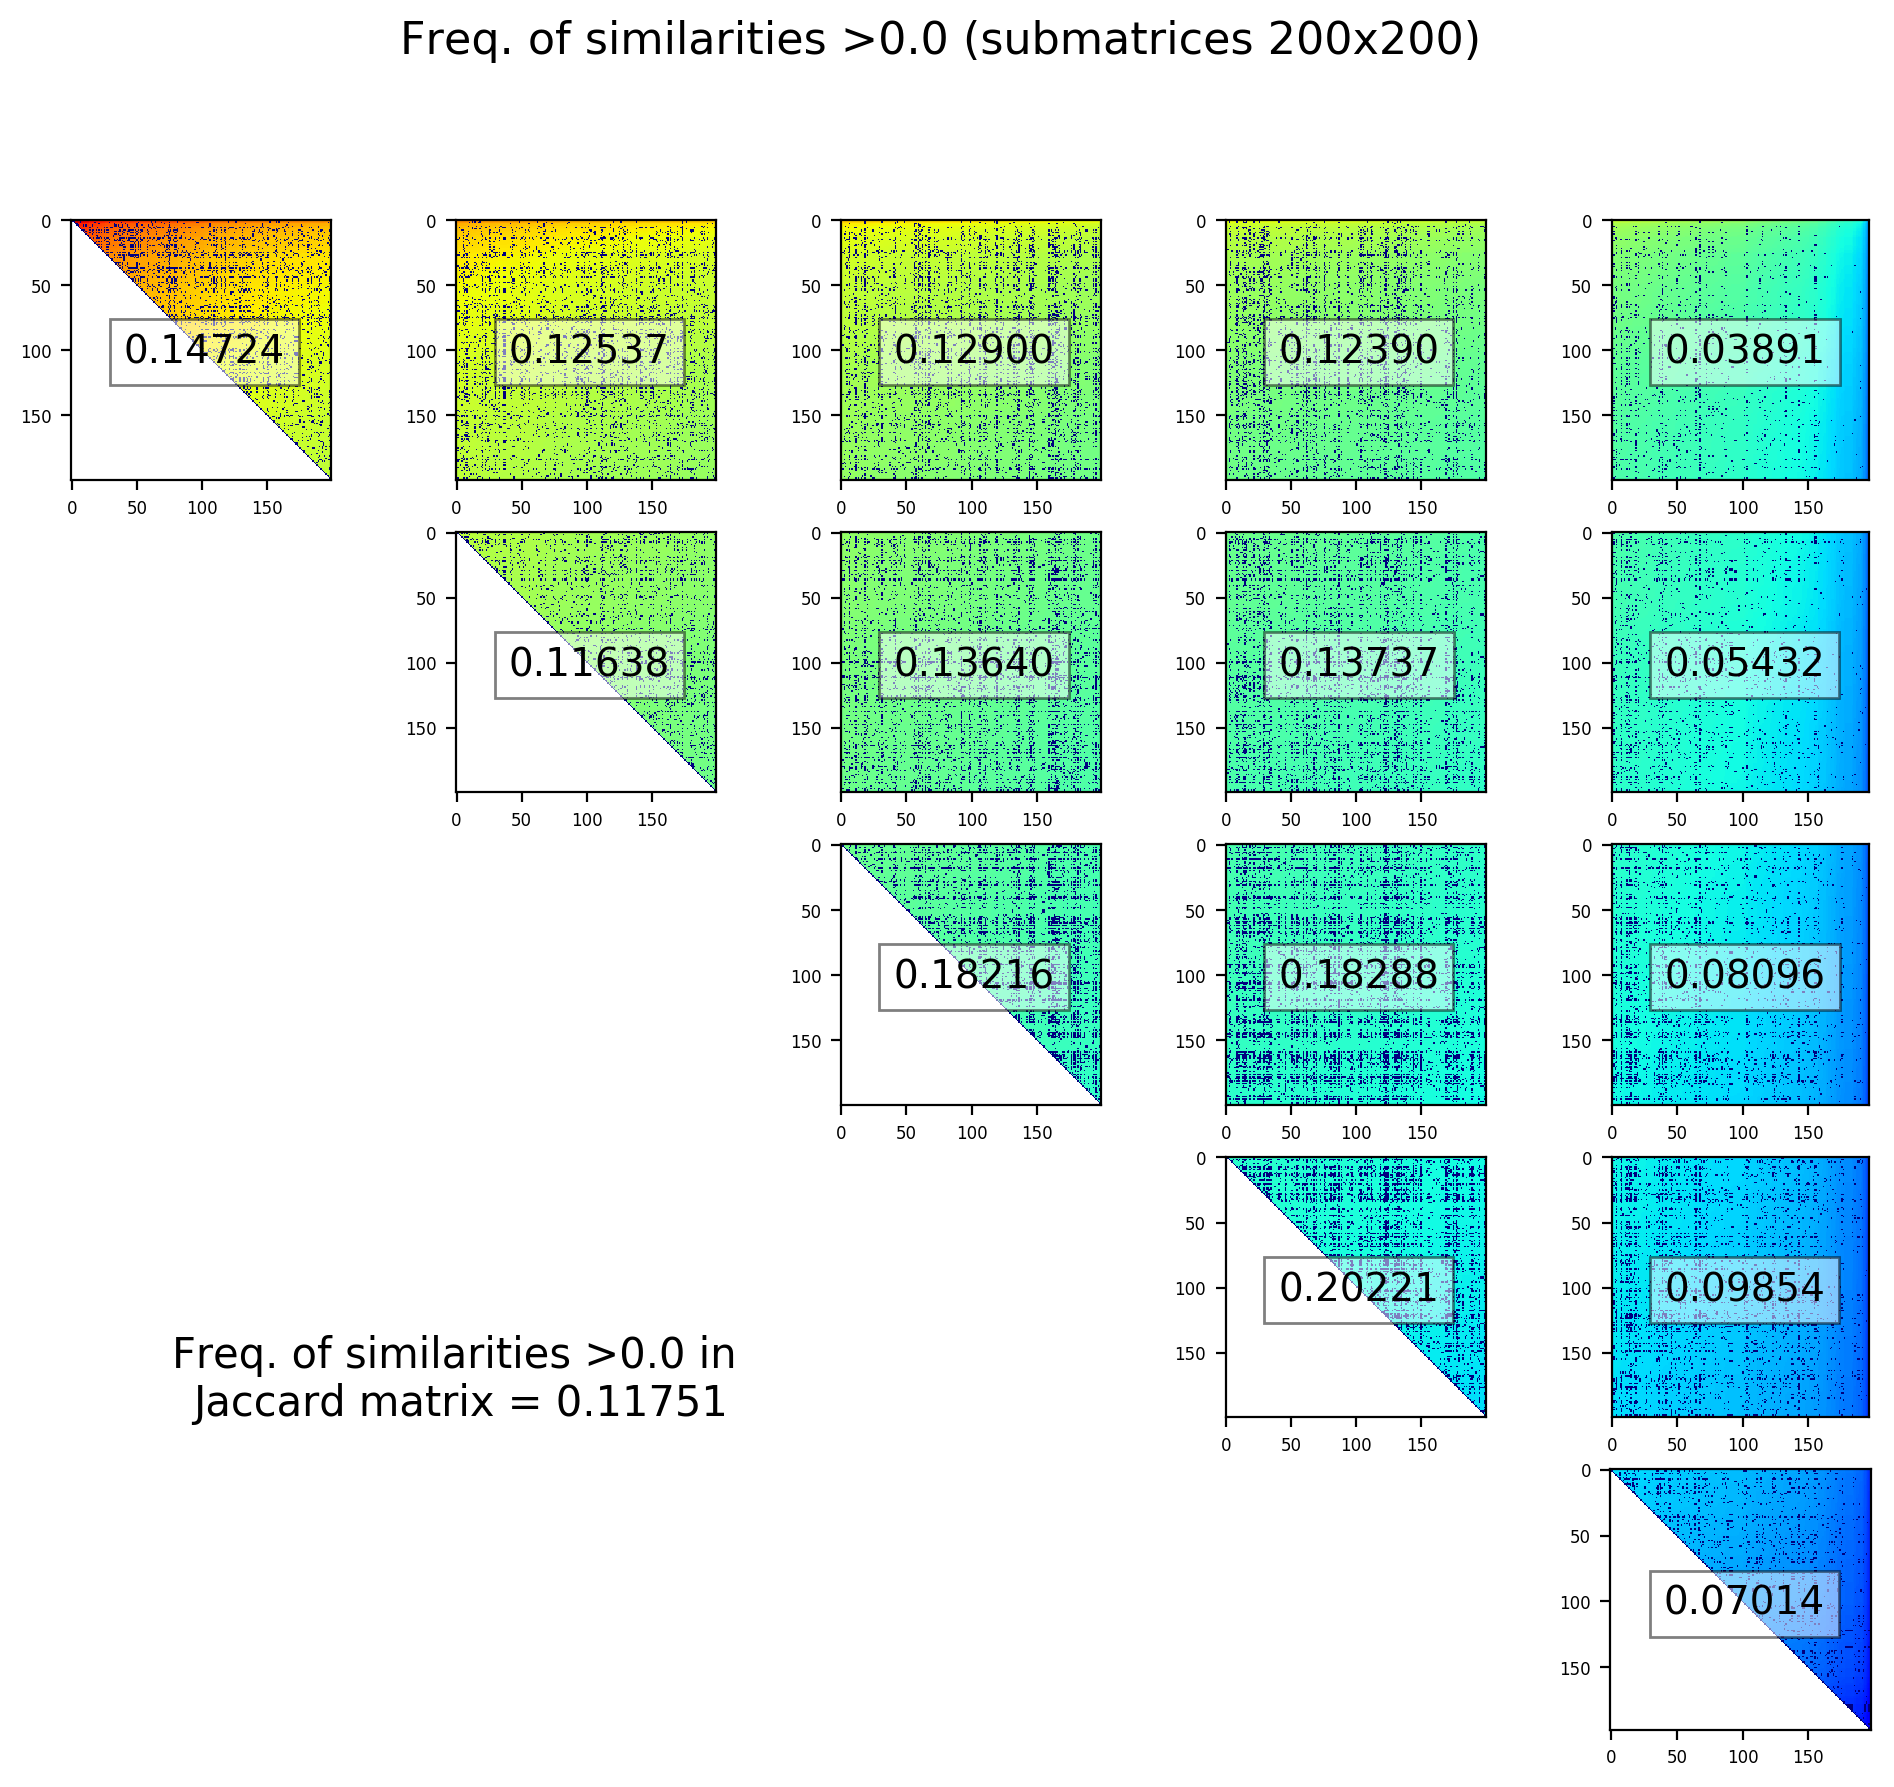

In [19]:
fig = plt.figure(figsize=(12,10))

n_subms = int(np.ceil(n/size_submatrix).tolist())
center_size_submatrix = size_submatrix/2
vmax=jaccardmask_word2vecapprox_ordered.max()

zero_sim_freq_full, gt_zero_sim_freq_full = freq_zero_jaccard_sim_triu(jaccard_mask_ordered)

fig.suptitle("Freq. of similarities >0.0 (submatrices %dx%d)" % (size_submatrix, size_submatrix), fontsize=16)

for i_subimage in range(0, n_subms):
    m_istart = i_subimage * size_submatrix
    m_iend = (i_subimage + 1) * size_submatrix
    j_subimage = i_subimage
    while j_subimage < n_subms:   
        m_jstart = j_subimage * size_submatrix
        m_jend = (j_subimage + 1) * size_submatrix
        
        submatrix_tmp = jaccardmask_word2vecapprox_ordered[m_istart:m_iend,m_jstart:m_jend]
        submask_tmp = jaccard_mask_ordered[m_istart:m_iend, m_jstart:m_jend]
        zero_sim_freq, gt_zero_sim_freq = freq_zero_jaccard_sim_triu(submask_tmp) if i_subimage == j_subimage else freq_zero_jaccard_sim_full(submask_tmp) 
        
        plt.subplot(n_subms, n_subms, j_subimage + (i_subimage*n_subms) + 1)     
        plt.text(center_size_submatrix - 60, 
                        center_size_submatrix + 10, 
                        '%.5f' % (gt_zero_sim_freq), 
                        fontsize=14, 
                        color='black',
                        bbox={'facecolor':'white', 'alpha':0.5, 'pad':5}
                   )
        
        im = plt.imshow(
                    np.ma.array(
                        submatrix_tmp, 
                        mask = subpltmask[:submatrix_tmp.shape[0],:submatrix_tmp.shape[0]] if i_subimage == j_subimage else None
                    ),
                    vmin=0.0, vmax=vmax
                )
        j_subimage += 1 

fig.text(0.3, 0.3, 'Freq. of similarities >0.0 in \nJaccard matrix = %.5f' % gt_zero_sim_freq_full, ha='center', va='center', size=15)

plt.show()

# Data samples 

## Document ids orderedby word2vec means.

In [20]:
indexdocs_ordered_word2vec = np.array(indexdocs)[word2vec_indices]
n_documents = 100 
ix_data_sample = rsdata.cur_indexed_sample(data_path)

## Bag-of-words of the first n documents

In [21]:
print("First %d documents in the ordered graph\n" % n_documents)
# print(indexdocs_ordered_word2vec[:n_documents])
for idoc in indexdocs_ordered_word2vec[:n_documents]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['indexdoc'], r['bag_of_words'])

First 100 documents in the ordered graph

index97023 algol simulation 68
index288618 partitioning algorithm
index201353 partitioning algorithm logic
index111566 graphical spatial applications audio
index74743 metaphors spatial spatialization user interfaces
index234054 graphs interfaces computer human
index525961 approach integrated dynamic manufacturing systems modeling
index171162 partitioning nonparametric algorithm multiclass
index256988 analysis workstations design multimedia subsystem
index486928 principles interfaces design human computer
index189817 analysis networks multilayer neural optimization
index541978 interfaces computer human cognitive complexity
index81445 data echnical warehousing architecture
index467054 ecl risc mips implementation cmos architecture
index363994 approach performance testing integrated analysis systems parallel
index186267 based software system module rigi construction interface model evolution specifications integration
index148329 human interfaces 

In [22]:
# print(indexdocs_ordered_word2vec[:n_documents])
for idoc in indexdocs_ordered_word2vec[:n_documents]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['indexdoc'], r['bag_of_words'])

index97023 algol simulation 68
index288618 partitioning algorithm
index201353 partitioning algorithm logic
index111566 graphical spatial applications audio
index74743 metaphors spatial spatialization user interfaces
index234054 graphs interfaces computer human
index525961 approach integrated dynamic manufacturing systems modeling
index171162 partitioning nonparametric algorithm multiclass
index256988 analysis workstations design multimedia subsystem
index486928 principles interfaces design human computer
index189817 analysis networks multilayer neural optimization
index541978 interfaces computer human cognitive complexity
index81445 data echnical warehousing architecture
index467054 ecl risc mips implementation cmos architecture
index363994 approach performance testing integrated analysis systems parallel
index186267 based software system module rigi construction interface model evolution specifications integration
index148329 human interfaces design issues computer
index278255 analysi

## Bag-of-words of the last n documents

In [40]:
print("\n\nLast %d documents in the ordered graph\n" % n_documents)
# print(indexdocs_ordered_word2vec[-n_documents:])
for idoc in indexdocs_ordered_word2vec[-n_documents:]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['indexdoc'], r['bag_of_words'])



Last 100 documents in the ordered graph

index160859 extracting lines straight
index153037 extracting lines straight
index94010 hull bounded complete space agr
index525587 information preparation future teacher searching
index160494 exhaustive 33 matrices order type cm hadamard cq williamson search
index214385 place 1992 conference interdisciplinary october design supported report computer during cooperative acm first took work day cscw describes 31 which workshop reports theory
index625162 internet 1st essential guide health psychotherapists edition mental professionals other
index4890 2007 office microsoft step excel
index525816 volumes irregular fast traverse
index618648 accounting problems principles ed 3rd
index519609 interpretation mdash issue part scenes special
index515189 motion shape sequence images recovering
index213357 motion shape sequence images recovering
index254567 1st assembly edition language programming ibm pc
index236945 symposium south communications processing

In [41]:
print("\n%d documents in the ordered graph\n" % n_documents)
# print(indexdocs_ordered_word2vec[-n_documents:])
for idoc in indexdocs_ordered_word2vec[n_documents*2:n_documents*3]:
    result = rsdata.find_indexdoc(ix_data_sample, idoc)
    for r in result:
        print(r['indexdoc'], r['bag_of_words'])


100 documents in the ordered graph

index205014 retrieval bases large optimal partitioning data multiple rectangular attribute
index416749 automatic workflows wrapper generation information environment enabling grid integration
index151156 systems tomorrow hardware fuzzy
index95398 hysteretic oscillators synchronization responses self coupled
index370600 techniques knowledge multimedia some learning enabling exploitation
index259810 mining visual oriented category data analysis
index346590 optimal matrix principle information method gradient memory throughout associative processes analog adaptive algorithms use shown distributed learning selectivity formed which related transform
index262027 system comemo knowledge community supporting evolution
index188360 metaknowledge based retrieval system expert knowledge distributed information office heuristics architecture automation learning
index186135 implications structures human knowledge problem computer solving interactive tasks
index58

In [25]:
# fig = plt.figure(figsize=(3,3))
A = tf.convert_to_tensor(word2vec_approximation)
B = tf.convert_to_tensor(jaccard_approximation)
A_B = A - B

with sess.as_default():
    Af1 = tf.sqrt(tf.trace(tf.matmul(A,tf.transpose(A)))) # Frobenius
    Af2 = tf.norm(A, ord='fro', axis=[1,0]) # Frobenius
   
    print("fnorm(A) ", Af1.eval(), Af2.eval())
 
    A_Bf1 = tf.norm(A_B, ord='fro', axis=[1,0]) # Frobenius

    print("fnorm(A - B) ", A_Bf1.eval())

    
    #plt.imshow(A.eval()[:,word2vec_indices][word2vec_indices,:])
    #plt.colorbar()
    #plt.show()


fnorm(A)  101.52154 101.52163
fnorm(A - B)  95.75481
